## Estimating the Sample Complexity of Binary Classifiers

In this notebook, we will estimate the sample complexity of the Perceptron, Winnow, 1-Nearest Neighbour and Least Squares algorithms using binary search. Sample complexity is defined as the number of training examples needed to achieve less than 10% generalisation error.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial.distance import cdist

In [4]:
class Perceptron:
    """
    Perceptron Classifier, requires online training
    """
    def __init__(self, n):
        self.w = np.zeros(n)
        
    def predict(self, x):
        return np.sign(x @ self.w)
    
    def train(self, X, y):
        for i in range(len(y)):
            x_t = X[i,:]
            y_t = y[i]

            y_hat = self.predict(x_t)

            if y_hat != y_t:
                self.w += x_t * y_t
        pass

In [5]:
class Winnow:
    """
    Winnow Classifier, requires online training
    """
    def __init__(self, n):
        self.n = n
        self.w = np.ones(n)
        
    def predict(self, x):
        return np.sign(x @ self.w - self.n)
    
    def train(self, X, y):
        for i in range(len(y)):
            x_t = X[i,:]
            y_t = y[i]
            
            y_hat = self.predict(x_t)

            if y_hat != y_t:
                self.w *= 2 ** (np.sign(y_t - y_hat) * x_t)
        pass

In [6]:
class LeastSquares:
    """
    Least Squares classifier
    """
    def __init__(self, n):
        self.n = n
        
    def train(self, X, y):
        self.w = np.linalg.pinv(X) @ y
        pass
        
    def predict(self, X):
        return np.sign(X @ self.w)

In [7]:
class OneNN:
    """
    One Nearest Neighbours Clasifier
    """
    def __init__(self, n):
        self.n = n
    
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
        pass
    
    def predict(self, X_test):
        # find distance between each row of X_test and X_train
        distances = cdist(X_test, self.X_train)
        
        # find index of minimum distance for each X_test
        min_indices = np.argmin(distances, axis=1)
        
        y_hat = self.y_train[min_indices]
        
        return y_hat

In [8]:
class SampleComplexity: 
    """
    Determines sample complexity for a classifier instance
    by utilising binary search to iterate over possible values
    """
    def __init__(self, classifier=None, n_max = 100, m_max=10_000, 
                 m_test=100, average_iters=20, error_threshold=0.1): 
        self.classifier = classifier
        self.n_max = n_max
        self.m_max = m_max
        self.m_test = m_test
        self.average_iters = average_iters
        self.error_threshold = error_threshold
        
        self.over_estimates = 0
        self.under_estimates = 0
        self.exact_estimates = 0
        
    def _generate_data(self, m:int, n:int):
        """
        Generates dataset for 'just a little bit' problem. m patterns 
        x1,..,xm are sampled uniformly at random from  {-1,1}^n
        """
        X = np.random.choice([-1,1],size=(m,n))
        y = X[:,0]
        return X,y
    
    def _bin_search(self, n:int):
        """
        Performs binary search to iterate over
        values of the number of samples to find
        the value that results in <10% generalisation error
        """
        m_low, m_high = 1, self.m_max
        
        while True:
            m = (m_low + m_high) // 2
            
            # generate data
            X_train, y_train = self._generate_data(m, n)
            X_test, y_test = self._generate_data(self.m_test, n) 
            
            # create classifier and train it
            classifier = self.classifier(n) 
            classifier.train(X_train, y_train)
            
            # test the classifier on 100 random test examples
            y_hat = classifier.predict(X_test)
            
            error_rate = np.count_nonzero(y_hat - y_test)/100
            
            if error_rate > self.error_threshold:
                if m_high - m < 2:
                    # binary search converged
                    self.under_estimates +=1
                    return m
                else:
                    # increase the lower search bound
                    m_low = m 
            else: #error less than 10%
                if m_high - m_low < 2: 
                    # binary search converged
                    if error_rate != 0.1:
                        self.over_estimates +=1
                    else:
                        self.exact_estimates +=1
                    return m
                else:
                    # decrease the upper search bound
                    m_high = m

    def run(self):
        """
        Runs binary search a number of times and returns the
        mean sample complexity for each dimension n and its
        standard deviation
        """
        n_dims = np.arange(1, self.n_max + 1) # values of data dimension
        m_means, m_stds = [], [] # sample complexity means & std devs
        
        print("running binary search \n...")
        for n in n_dims:
            # compute sample complexity many times
            sample_complexity = [self._bin_search(n) 
                                 for i in range(self.average_iters)]
            
            # store mean and standard deviation of sample complexity
            m_means.append(np.mean(sample_complexity))
            m_stds.append(np.std(sample_complexity))
        print("number of underestimates to overestimates ratio:",
              f"{self.under_estimates/self.over_estimates:.2f}")
        print("done!")
        
        return n_dims, np.array(m_means), np.array(m_stds)

#### Perceptron

In [9]:
start = time.time()

classifier = SampleComplexity(Perceptron)
n_dims_perc, m_means_perc, m_stds_perc= classifier.run()

end = time.time()
print(f"execution time: {end - start:.2f}s")

running binary search 
...
number of underestimates to overestimates ratio: 2.08
done!
execution time: 120.02s


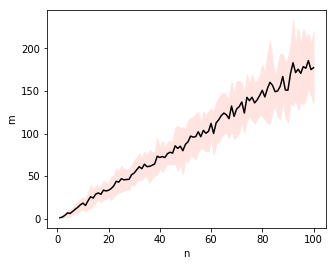

In [10]:
plt.subplots(figsize=(5,4))

# plot mean
plt.plot(n_dims_perc, m_means_perc, color='black')
# plot errors, +-standard deviation
plt.gca().fill_between(n_dims_perc, m_means_perc-m_stds_perc, 
                       m_means_perc + m_stds_perc, color="mistyrose")

# format and save plot
plt.ylabel('m')
plt.xlabel('n')
plt.show()


#### Winnow

In [11]:
start = time.time()

classifier = SampleComplexity(Winnow)
n_dims_winn, m_means_winn, m_stds_winn= classifier.run()

end = time.time()
print(f"execution time: {end - start:.2f}s")

running binary search 
...
number of underestimates to overestimates ratio: 1.86
done!
execution time: 94.44s


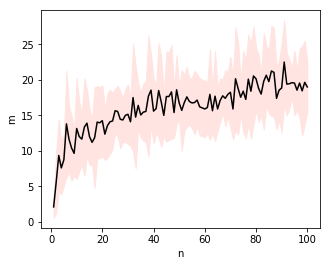

In [12]:
plt.subplots(figsize=(5,4))

# plot mean
plt.plot(n_dims_winn, m_means_winn, color='black')
# plot errors, +-standard deviation
plt.gca().fill_between(n_dims_winn, m_means_winn-m_stds_winn, 
                       m_means_winn + m_stds_winn, color="mistyrose")

# format and save plot
plt.ylabel('m')
plt.xlabel('n')
plt.show()


#### Least Squares

In [13]:
start = time.time()

classifier = SampleComplexity(LeastSquares)
n_dims_ls, m_means_ls, m_stds_ls= classifier.run()

end = time.time()
print(f"execution time: {end - start:.2f}s")

running binary search 
...
number of underestimates to overestimates ratio: 2.72
done!
execution time: 84.63s


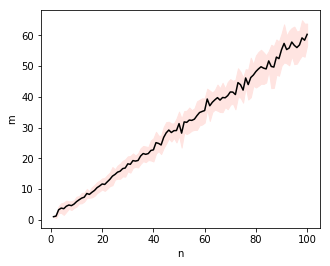

In [14]:
plt.subplots(figsize=(5,4))

# plot mean
plt.plot(n_dims_ls, m_means_ls, color='black')
# plot errors, +-standard deviation
plt.gca().fill_between(n_dims_ls, m_means_ls-m_stds_ls, 
                       m_means_ls + m_stds_ls, color="mistyrose")

# format plot
plt.ylabel('m')
plt.xlabel('n')
plt.show()

#### 1-NN

In [15]:
start = time.time()

classifier = SampleComplexity(OneNN)
n_dims_nn, m_means_nn, m_stds_nn= classifier.run()

end = time.time()
print(f"execution time: {end - start:.2f}s")

running binary search 
...
number of underestimates to overestimates ratio: 15.66
done!
execution time: 1301.52s


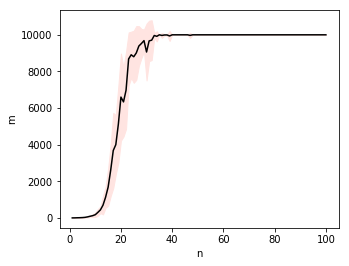

In [16]:
plt.subplots(figsize=(5,4))

# plot mean
plt.plot(n_dims_nn, m_means_nn, color='black')
# plot errors, +-standard deviation
plt.gca().fill_between(n_dims_nn, m_means_nn-m_stds_nn, 
                       m_means_nn + m_stds_nn, color="mistyrose")

# format plot
plt.ylabel('m')
plt.xlabel('n')
plt.show()

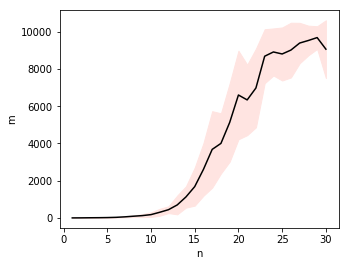

In [17]:
plt.subplots(figsize=(5,4))

# plot mean
plt.plot(n_dims_nn[:30], m_means_nn[:30], color='black')
# plot errors, +-standard deviation
plt.gca().fill_between(n_dims_nn[:30], m_means_nn[:30]-m_stds_nn[:30], 
                       m_means_nn[:30] + m_stds_nn[:30], color="mistyrose")

# format and save plot
plt.ylabel('m')
plt.xlabel('n')
plt.show()

#### All classifiers

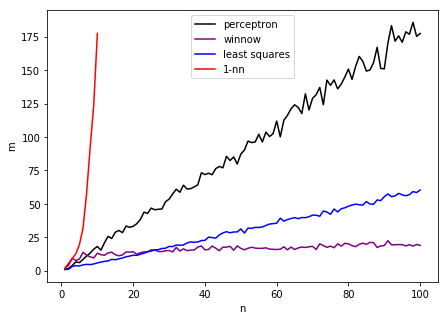

In [18]:
plt.subplots(figsize=(7,5))

plt.plot(n_dims_perc, m_means_perc, color='black', label='perceptron')
plt.plot(n_dims_perc, m_means_winn, color='purple', label='winnow')
plt.plot(n_dims_perc, m_means_ls, color='blue', label='least squares')
plt.plot(n_dims_perc[:10], m_means_nn[:10], color='red', label='1-nn')

# format and save plot
plt.ylabel('m')
plt.xlabel('n')
plt.legend(loc='upper center')
plt.show()